## WIFI encrypted CLASSIFIER

A machine-learning classifier able to dis6nguish what kind of ac6vity a user is performing with his/her smartphone/laptop by sniffing traffic in monitor mode.

a. Sniff traffic in monitor mode from a known MAC address 

b.  extract statistical features from the traffic every W seconds:
  - number of packets up/down
  - average and variance of the packet size
  - average and variance of the inter-arrival packet times

  max, min, mean and standar deviation
  from a to b, control packets transport protocol

c. choose a pre-trained machine-learning classifier 
d. to recognize the user activity among at least the following
   - idle, web browsing, YouTube streaming
e. Report the accuracy of the approach through a confusion matrix

a. Sniff traffic in monitor mode from a known MAC address 

In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import display


def get_sample_id(packet_time, first_timestamp, W):
    return math.floor( (packet_time - first_timestamp)/W )

def sample_data(sniff, W):
    first_timestamp = sniff["Time"].min()
    print("first_timestamp",first_timestamp,W)
    sniff["sample_no"] = sniff["Time"].apply(lambda x:get_sample_id(x,first_timestamp, W))

    return sniff

def load_data(csv):
    # read each X seconds, take statistics
    # ((wlan.sa == aa:3a:0e:b6:ed:12  or wlan.da == aa:3a:0e:b6:ed:12 ) ) && (wlan.fc.type_subtype == 0x0028)
    # import csv
    sniff = pd.read_csv('./csvs/{}_completed.csv'.format(csv))
    return sniff
def get_stats(data, label):
    process_data = pd.DataFrame()
    data['IAT'] = data["Time"].diff()
    groupedBySample = data.groupby("sample_no")

    # avrg and variance packet size
    process_data["avrg_len"] = groupedBySample["Length"].mean()
    process_data["var_len"] = groupedBySample["Length"].var(ddof=0)

    # avrg and variance inter-arrival-times
    process_data["avrg_IAT"] = groupedBySample["IAT"].mean()
    process_data["var_IAT"] = groupedBySample["IAT"].var(ddof=0)

    # packets count and down up link count
    SRC_MAC = 'aa:3a:0e:b6:ed:12'
    count = groupedBySample.size()
    process_data["count"] = count
    upload_count = data.loc[ data["Source"] == SRC_MAC ].groupby("sample_no").size() # get only uplink packets
    process_data["upload_percentage"] = upload_count/count


     # count of QoS types
    qos_types_subtypes = [
        "Best Effort (Best Effort)",
        "Background (Background)",
        "Spare (Background)",
        "Excellent Effort (Best Effort)",
        "Controlled Load (Video)",
        "Video (Video)",
        "Voice (Voice)",
        "Network Control (Voice)"
    ]

    qos_columns = []
    for i,type in enumerate(qos_types_subtypes):
        column = "qos_type{}".format(i)
        qos_columns = [*qos_columns, column]
        process_data[column] = data.loc[ data["wlan.qos.priority"] == type ].groupby("sample_no").size()
        process_data[column] = process_data[column].fillna(0)
        process_data[column] = process_data[column] / count

    return process_data.reset_index()



b.  extract statistical features from the traffic every W seconds:
  - number of packets up/down
  - average and variance of the packet size
  - average and variance of the inter-arrival packet times

  max, min, mean and standar deviation
  from a to b, control packets transport protocol

In [98]:
# create X
#   limpiar campos 
#   obtener solo del objective mac
#       original source (SA), final destination (DA), and the immediate sending/receiving systems (TA/RA)
#   obtener estatistiticas
def process_packets(W):
    data = [["browsing", "browsing"],["call1","online_streaming"],["call2","online_streaming"],["idle","idle"],["youtube","youtube"]]
    final_set = pd.DataFrame()
    for i,[csv, label] in enumerate(data):
        sniff = load_data(csv)
        samples = sample_data(sniff, W)
        stats = get_stats(samples, label)

        #label set
        stats["gt"] = stats["sample_no"].apply(lambda x: label)
        final_set = pd.concat([final_set,stats])
    
    final_set.to_csv('test.csv')
    return final_set



c. choose a pre-trained machine-learning classifier 
d. to recognize the user activity among at least the following
   - idle, web browsing, YouTube streaming
e. Report the accuracy of the approach through a confusion matrix

first_timestamp 0.0 2
first_timestamp 0.0 2
first_timestamp 0.0 2
first_timestamp 0.0 2
first_timestamp 0.0 2
0.7124645892351275
0.7124645892351275
0.7351274787535411
0.7294617563739377


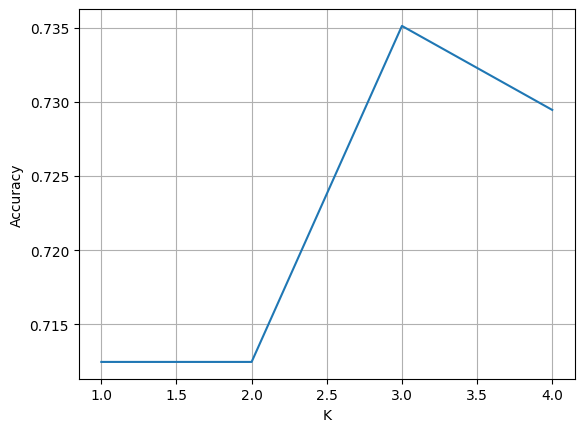

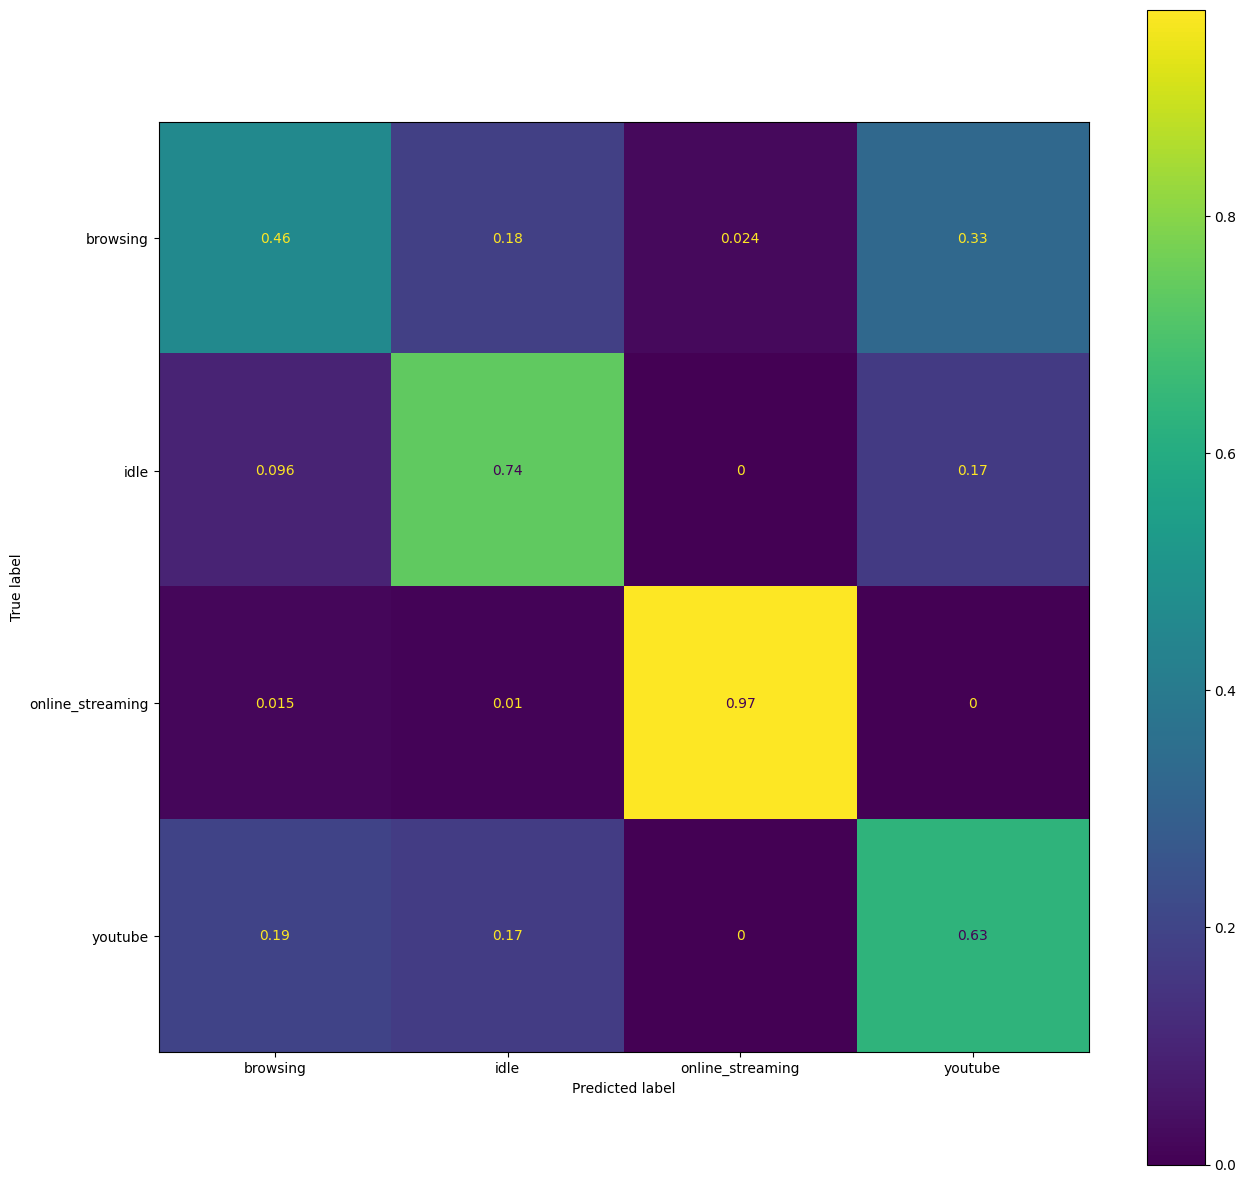

In [106]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

scaler = StandardScaler()    

sample_window = 2 # seconds
X = process_packets(sample_window)
X = X.dropna()
Y = X["gt"]
X = X.drop('gt',axis=1)

X_norm = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.5)

ACCURACY = []
for k in range(1,5):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(y_test, knn_predict)
  ACCURACY.append(accuracy)
  print(accuracy)

fig = plt.figure();
plt.plot(range(1,5),ACCURACY);
plt.grid(visible=True);
plt.xlabel('K');
plt.ylabel('Accuracy');

bestk = np.argmax(ACCURACY)+1
knn = KNeighborsClassifier(n_neighbors=bestk, weights='distance')
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(knn_predict, y_test, ax=ax, normalize='true')


